In [1]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from python import prepare_inputs as pi
from python import solar_utils as su
from python import wind_utils as wu
from python import hydro_utils as hu
from python import utils as pu

from python.utils import project_path
from python.building_elec_model import building_types_dict

# Input data for a run

In [2]:
# Read GenX
df_genX = pd.read_csv(f'{project_path}/data/genX/capacity_Low_RE_High_Elec.csv')
df_genX = pi.tidy_genX(df_genX).query('EndCap > 1.')

In [3]:
# Read GenX downscaled
df_genX_ds = pd.read_csv(f'{project_path}/data/genX/selected_CPA_Combined_Capacity_Low_RE_High_Elec.csv')

df_genX_ds = (df_genX_ds[(df_genX_ds['state'] == 'New York') & (df_genX_ds['iter'] == 0)]
              .drop_duplicates(subset=['Resource', 'Zone'], keep='first')
              .query('EndCap > 1.')
             )

df_genX_ds.groupby('Resource_Type')['EndCap'].sum()

Resource_Type
Utility_PV    23133.29392
Name: EndCap, dtype: float64

In [4]:
# Run name (make sure matches above!)
run_name = "low_RE_high_elec_iter0_default"

run_path = f"{project_path}/runs/{run_name}"

Path(f"{run_path}/inputs").mkdir(parents=True, exist_ok=True)
Path(f"{run_path}/outputs").mkdir(parents=True, exist_ok=True)

In [5]:
# Read ACORN generators
df_genprop_bo = pd.read_csv(f'{project_path}/data/grid/gen_prop_boyuan.csv')
df_gencost_bo = pd.read_csv(f'{project_path}/data/grid/gencost_prop_boyuan.csv')

# Merge costs and info
df_genprop = pd.merge(df_gencost_bo, df_genprop_bo)

# Select NYS only
df_genprop = df_genprop[df_genprop['GEN_ZONE'].isin(pu.zone_names)]

### Thermal

In [130]:
# Match thermal capacities (natural gas only)
df_ng_matched = pi.match_ng_capacity(df_genX,
                                     df_genprop,
                                     store_path = run_path,
                                     retirement_method='highest_cost_first')

Starting capacity matching process...

Capacity comparison:
Zone | Current (MW) | Target (MW) | Difference (MW)
-------------------------------------------------------
A    |       393.0 |      536.8 |         143.8
Zone A: Added 3 duplicate generators, increasing capacity by 144.0 MW (target: 143.8 MW)
B    |       109.0 |      269.1 |         160.1
Zone B: Added 3 duplicate generators, increasing capacity by 175.0 MW (target: 160.1 MW)
C    |      1709.0 |     1672.9 |         -36.1
Zone C: Retired 1 generators, reducing capacity by 110.0 MW (target: 36.1 MW)
D    |       346.0 |      371.0 |          25.0
Zone D: Added 1 duplicate generators, increasing capacity by 51.0 MW (target: 25.0 MW)
E    |       206.0 |      201.6 |          -4.4
Zone E: Retired 1 generators, reducing capacity by 45.0 MW (target: 4.4 MW)
F    |      3159.0 |     3797.5 |         638.5
Zone F: Added 3 duplicate generators, increasing capacity by 970.0 MW (target: 638.5 MW)
G    |      1761.0 |     2015.0 |   

### Nuclear

In [122]:
# GenX
df_genX.query('Resource == "nuclear"')[['Resource', 'Zone', 'EndCap']]

,Resource,Zone,EndCap
178,nuclear,C&E,2699.998583


In [123]:
# ACORN
df_genprop[df_genprop['FUEL_TYPE'] == 'UR'][['GEN_NAME', 'PMAX', 'GEN_ZONE', 'GEN_STATUS']]

,GEN_NAME,PMAX,GEN_ZONE,GEN_STATUS
236,Indian Point 2,1026.5,H,1
237,Indian Point 3,1040.4,H,1
238,James A. FitzPatrick,858.9,C,1
239,Nine Mile Point 1,630.5,C,1
240,Nine Mile Point 2,1246.6,C,1
241,R. E. Ginna,582.0,B,1


In [128]:
# Match nuclear by hand -> keep only nuclear in zone C
# Retire all nuclear outside zone C
df_nuclear = df_genprop[(df_genprop['FUEL_TYPE'] == 'UR') & (df_genprop['GEN_ZONE'] == 'C')]
# Store
df_nuclear.to_csv(f"{run_path}/inputs/genprop_nuclear_matched.csv", index=False)

### Hydro

In [6]:
# Read historical
df_hydro_hist = pd.read_csv('../data/hydro/godeeep-hydro/godeeep-hydro-historical-weekly.csv')
df_hydro_plants = pd.read_csv('../data/hydro/godeeep-hydro/godeeep-hydro-plants.csv')

In [58]:
df_hydro_plants

,eia_id,plant,mode,state,lat,lon,nameplate_capacity,nerc_region,ba,max_param,min_param,ador_param,huc2
0,541,Bulls Bridge,RoR,CT,41.67810,-73.50900,7.2,NPCC,ISNE,0.45949,0.39873,0.44611,1
1,551,Scotland Dam,RoR,CT,41.66490,-72.12260,2.0,NPCC,ISNE,0.45949,0.39873,0.44611,1
2,552,Shepaug,Storage,CT,41.44790,-73.29640,37.2,NPCC,ISNE,0.62022,0.35792,0.33761,1
3,553,Stevenson,Storage,CT,41.38320,-73.17210,30.5,NPCC,ISNE,0.62022,0.35792,0.33761,1
4,554,Taftville,Storage,CT,41.57271,-72.04559,1.6,NPCC,ISNE,0.62022,0.35792,0.33761,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,54654,Kekawaka Power House,RoR,CA,40.11070,-123.46600,4.9,WECC,CISO,0.45949,0.39873,0.44611,18
1448,55009,Montgomery Creek Hydro,Storage,CA,40.83620,-121.93900,2.6,WECC,CISO,0.62022,0.35792,0.33761,18
1449,56125,Springville Hydroelectric,Storage,CA,34.22730,-119.08630,1.0,WECC,CISO,0.62022,0.35792,0.33761,18
1450,57854,North Hollywood,Storage,CA,34.19444,-118.39028,6.1,WECC,LDWP,0.62022,0.35792,0.33761,18


In [7]:
# Subset to NYISO plants
nyiso_plants = df_hydro_plants[df_hydro_plants['ba'] == "NYIS"]['eia_id']
df_hydro_hist = df_hydro_hist[df_hydro_hist['eia_id'].isin(nyiso_plants)].copy()
df_hydro_hist['datetime'] = pd.to_datetime(df_hydro_hist['datetime'])

In [62]:
# For Robert-Moses Niagara we model the diurnal pattern
df_niagara = hu.disaggregate_weekly_to_hourly(
    df = df_hydro_hist[df_hydro_hist['plant'] == 'Robert Moses Niagara'].copy(),
    method='diurnal'
)

In [63]:
df_niagara

power_mw
eia_id datetime                        
2693   1982-01-01 00:00:00  1739.380452
       1982-01-01 01:00:00  1751.960792
       1982-01-01 02:00:00  1784.891986
       1982-01-01 03:00:00  1856.757655
       1982-01-01 04:00:00  1986.258124
...                                 ...
       2019-12-31 19:00:00  3164.511248
       2019-12-31 20:00:00  2944.856202
       2019-12-31 21:00:00  2651.165606
       2019-12-31 22:00:00  2355.649480
       2019-12-31 23:00:00  2111.032951

[333096 rows x 1 columns]

<Axes: xlabel='datetime'>

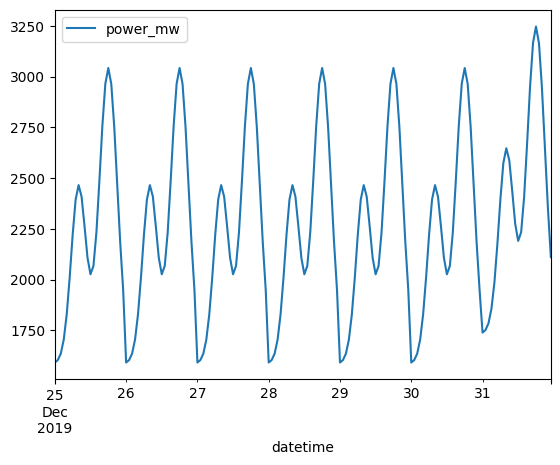

In [33]:
df_niagara.iloc[-168:].plot(x='datetime', y='power_mw')

In [59]:
import importlib
importlib.reload(hu)

<module 'python.hydro_utils' from '/home/fs01/dcl257/projects/acorn-julia/src/python/hydro_utils.py'>

In [60]:
# For others we assume constant
df_others = hu.disaggregate_weekly_to_hourly(
    df = df_hydro_hist[df_hydro_hist['plant'] != 'Robert Moses Niagara'].copy(),
    method='average'
)

In [61]:
df_others

p_avg
eia_id datetime                    
88     1982-01-01 00:00:00  2.14404
       1982-01-01 01:00:00  2.14404
       1982-01-01 02:00:00  2.14404
       1982-01-01 03:00:00  2.14404
       1982-01-01 04:00:00  2.14404
...                             ...
61642  2019-12-30 20:00:00  0.78334
       2019-12-30 21:00:00  0.78334
       2019-12-30 22:00:00  0.78334
       2019-12-30 23:00:00  0.78334
       2019-12-31 00:00:00  1.50000

[53291680 rows x 1 columns]

### Solar

In [55]:
#######################
# Existing solar: DPV
#######################
# Generate existing onshore sites
df_genX_solar_dpv = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'distributed_generation'].copy(),
                                               genX_zone_col='Zone')

df_genX_solar_dpv = su.generate_solar_sites(df_genX_solar_dpv, sites_per_zone=10)

# TGW climate data
climate_scenario = "historical_1980_2019"

# climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))
climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
                          for year in range(1980, 1981)]).flatten()

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar_dpv = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_solar_dpv,
    climate_paths = climate_paths,
    correction_file = correction_file,
    PV_bus_only = False
)

# Store
df_solar_dpv.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/solar_dpv_{climate_scenario}.csv")

In [8]:
####################
# Existing solar
####################
# Generate existing onshore sites
df_genX_solar_existing = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'solar_existing'].copy(),
                                                   genX_zone_col='Zone')

df_genX_solar_existing = su.generate_solar_sites(df_genX_solar_existing)

# TGW climate data
climate_scenario = "historical_1980_2019"

# climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))
climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
                          for year in range(1980, 1981)]).flatten()

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar_existing = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_solar_existing,
    climate_paths = climate_paths,
    correction_file = correction_file,
)

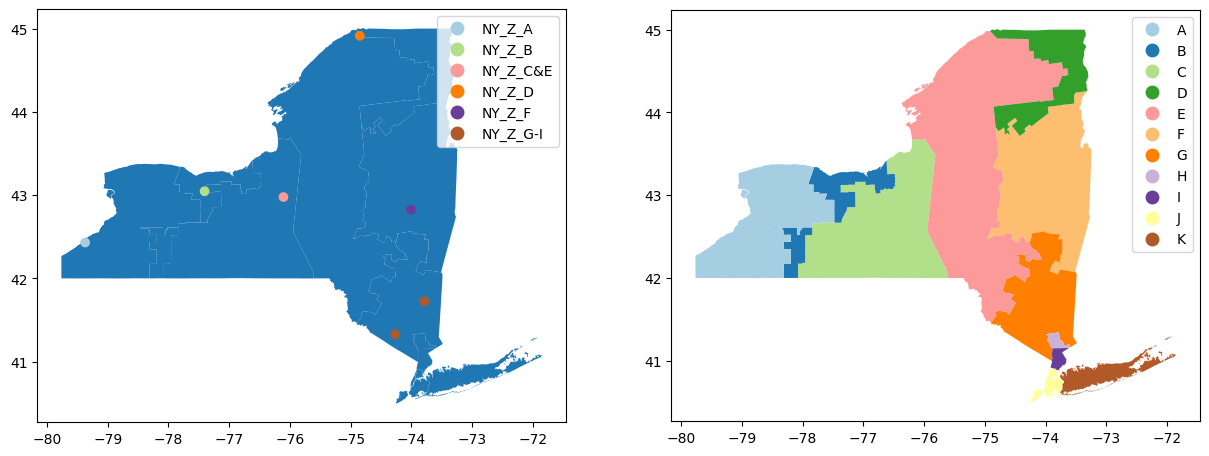

In [47]:
################################################################
# NOTE: The genX zones do not always align with their coordinates
# (i.e. they will be assigned to a different zone).
# When aggregating to bus level, assigning `match_zone` = True
# means that genX zones will be respected. `match_zone` = False
# means it will use the lat/lon coords instead.
################################################################
# Read NYISO shapefile
nyiso_gdf = gpd.read_file(f'{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp')

# Plot
fig, axs = plt.subplots(1,2, figsize=(15,10))

nyiso_gdf.plot(ax=axs[0])
pu.merge_to_zones(df_genX_ds[df_genX_ds['Resource_Type'] == 'Utility_PV'],
               lat_name='latitude',
               lon_name='longitude').plot(ax=axs[0], column='region', legend=True, cmap='Paired')

nyiso_gdf.plot(ax=axs[1], column='zone', legend=True, cmap='Paired')

plt.show()

In [11]:
####################
# New solar
####################
# Update the genX regions
df_genX_ds_solar = df_genX_ds[df_genX_ds['Resource_Type'] == 'Utility_PV'].copy()
df_genX_ds_solar = pu.map_genX_zones_to_nyiso(df_genX_ds_solar, C_and_E_mapping='C')

# TGW climate data
climate_scenario = "historical_1980_2019"

# climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))
climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
                          for year in range(1980, 1981)]).flatten()

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar_new = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_ds_solar,
    climate_paths = climate_paths,
    correction_file = correction_file,
)

In [12]:
# Combined solar
df_solar_total = pd.concat([df_solar_existing, df_solar_new])
df_solar_total = df_solar_total.reset_index().groupby(['bus_id', 'datetime']).sum()

# Store combined
df_solar_total.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/solar_upv_{climate_scenario}.csv")

### Wind

In [13]:
# Read NYISO shapefile
nyiso_gdf = gpd.read_file(f'{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp')

In [17]:
########################
# Existing onshore wind
########################
# Generate existing onshore sites
df_genX_onshore_existing = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'onshore_wind_existing'].copy(),
                                                      genX_zone_col='Zone')

df_genX_onshore_existing = wu.generate_onshore_wind_sites(df_genX_onshore_existing)

# TGW climate data
climate_scenario = "historical_1980_2019"

# climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))
climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
                          for year in range(1980, 1981)]).flatten()

# Stability coefficients
stab_coef_file = f"{pu.project_path}/data/wind/models/tgw_wind_stability_coefficients_2007-2007_every100.csv"

# Calculate the timeseries
df_onshore_wind = wu.calculate_wind_timeseries_from_genX(
    df_genX = df_genX_onshore_existing,
    climate_paths = climate_paths,
    stab_coef_file = stab_coef_file,
    iec_curve = 'iec1',
)

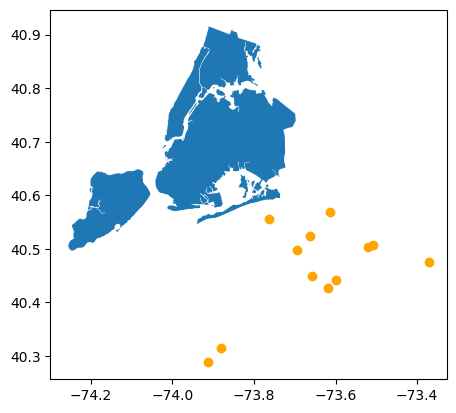

In [18]:
########################
# Existing offshore wind
########################
### Generate sites
# Read NYISO shapefile
nyiso_gdf = gpd.read_file(f'{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp')

# Generate offshore locations
df_genX_offshore_existing = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'offshore_wind'].copy(),
                                                      genX_zone_col='Zone')

df_genX_offshore_existing = wu.generate_offshore_wind_sites(df_genX_offshore_existing)

# Check
fig, ax = plt.subplots()
nyiso_gdf[nyiso_gdf['zone'].isin(df_genX_offshore_existing['genX_zone'].unique())].plot(ax=ax)
df_genX_offshore_existing.plot(ax=ax, color='orange')
plt.show()

# Generate timeseries
# TGW climate data
climate_scenario = "historical_1980_2019"

# climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))
climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
                          for year in range(1980, 1981)]).flatten()

# Stability coefficients
stab_coef_file = f"{pu.project_path}/data/wind/models/tgw_wind_stability_coefficients_2007-2007_every100.csv"

# Calculate the timeseries
df_offshore_wind = wu.calculate_wind_timeseries_from_genX(
    df_genX = df_genX_offshore_existing,
    climate_paths = climate_paths,
    stab_coef_file = stab_coef_file,
    iec_curve = 'offshore',
)

In [22]:
# Combined wind
df_wind_total = pd.concat([df_onshore_wind, df_offshore_wind])
df_wind_total = df_wind_total.reset_index().groupby(['bus_id', 'datetime']).sum()

# Store combined
df_wind_total.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/wind_{climate_scenario}.csv")

### Load

In [227]:
# Settings
climate_scenario = "historical_1980_2019"
resstock_mulitplier = 0.1

In [222]:
# Read baseline
df_baseline = pd.read_parquet(f"../data/load/baseline/simulated/load_model_tgw_multizone_NN_{climate_scenario}.parquet")
df_baseline = df_baseline[df_baseline['datetime'].dt.year == 1980]
df_baseline = df_baseline.groupby(['bus_id', 'datetime'])[['load_MW']].sum(numeric_only=True)

In [228]:
# Read ResStock
upgrade = 1
df_resstock = pd.concat([pd.read_parquet(f"{project_path}/data/load/resstock/simulated/bus_level/{climate_scenario}_{upgrade}_{home_type}.parquet") for home_type in building_types_dict['resstock']])
df_resstock = df_resstock.reset_index()
df_resstock = df_resstock[df_resstock['time'].dt.year == 1980]
df_resstock = df_resstock.groupby(['bus_id','time']).sum() * resstock_mulitplier

In [224]:
# Read ComStock
upgrade = 31
df_comstock = pd.concat([pd.read_parquet(f"{project_path}/data/load/comstock/simulated/bus_level/{climate_scenario}_{upgrade}_{home_type}.parquet") for home_type in building_types_dict['comstock']])
df_comstock = df_comstock.reset_index()
df_comstock = df_comstock[df_comstock['time'].dt.year == 1980]
df_comstock = df_comstock.groupby(['bus_id','time']).sum()

In [229]:
# Combine
df_load = pd.concat([df_comstock.reset_index().rename(columns={'bus_load_MW':'load_MW', 'time':'datetime'}),
                     df_resstock.reset_index().rename(columns={'bus_load_MW':'load_MW', 'time':'datetime'}),
                     df_baseline.reset_index()]).groupby(['bus_id', 'datetime']).sum()

<Axes: xlabel='datetime'>

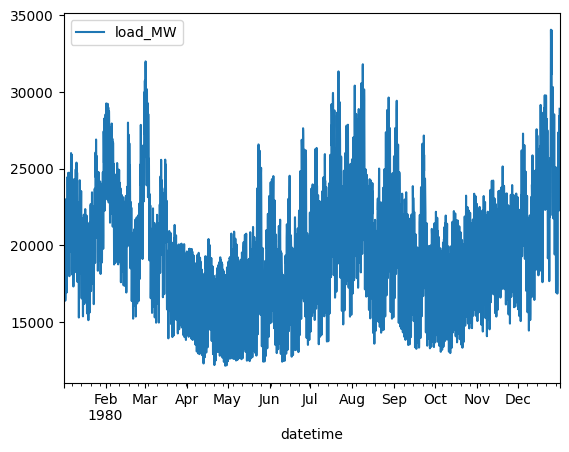

In [230]:
df_load.groupby('datetime').sum().plot()

In [233]:
# Store
df_load.reset_index().pivot(index='bus_id', 
                            columns='datetime', 
                            values='load_MW').to_csv(f"{run_path}/inputs/load_{climate_scenario}.csv")